### Robot Learning

### Assignment 5

Solutions are due on 17.05.2022 before the lecture.

### Introduction

Please carefully read the following description of the card game *Blackjack*.

The goal of Blackjack is to draw cards such that their values sum to as close to 21 as possible, but do not exceed 21. All cards 2 through 10 are assigned their number as the respective value, face cards like Jack, Queen and King yield a value of 10 points. The aces are special; they can count as either 1 or 11, depending on what is more beneficial. When using the ace as 11 points does not cause the total value of the hand to exceed 21, the ace is called 'usable'. 

The actions are to *stick*, which means to stop drawing cards and let the dealer play, or to *hit*, which means to draw another card to add to your hand. 

The opponent is a dealer with a fixed strategy; the dealer will always hit when the dealer's sum of card values is below 17 points. At or above 17 points, the dealer immediately sticks, irrespective of the player's card sum. Note that the dealer only starts playing once the player is finished, so when the player has selected to stick.

The game starts by drawing two cards each to player and dealer from an infinite deck. The player can see the own cards, but only the first card which the dealer recieves, the other is face-down. If the player hits and exceeds 21 points, the player is considered *bust* and immediately loses the game. When the player decides to stick, the dealer will draw cards according to its strategy. If the dealer goes *bust* in the process, the player immediately wins the game. If not, the sum of the dealer's card values is compared to the sum of the player's card values. If they are equal, the game is considered a draw. If the player has a higher score, the player wins, and vice versa.

In this RL setting, the rewards are +1 for winning, -1 for losing, and 0 for drawing and all intermediate moves. The state is a 3-tuple consisting of the players current hand sum, the value of the dealer's initial open card and a boolean describing whether the player currently has a usable ace or not. The action space consists of the integer $0$, which corresponds to *stick*, and the integer $1$, which corresponds to *hit*. Note that this corresponds exactly to the scenario described in [Example 5.1 in Reinforcement Learning: An Introduction by Sutton and Barto.](http://incompleteideas.net/book/the-book-2nd.html)

To get started, please examine the following code cell, which loads the Blackjack environment from the utils file and plays an episode. The player is in this case the random agent. The environment is equivalent to the one provided in OpenAI Gym; we adapted the source code so that installing this python package is not necessary.

In [1]:
import numpy as np
from helpers.utils import BlackjackEnv

np.random.seed(2022)
# create a Blackjack environment
casino = BlackjackEnv()

# do this before each new episode
# state is 3-tuple: (player_current_sum, dealer_first_open_card, usable_ace_bool)
# if dealer_first_open_card == 1, the dealer is holding an ace!
starting_state = casino.reset()

# create flag tracking whether the episode is over
done = False

# create lists to save the trajectory and the decisions of the agent
actions, rewards, states = [], [], [starting_state]

# simulate until the episode is over
while not done:
    #in each non-terminal state the agent can either stick (0) or hit (1)
    possibleActions = casino.getAvailableActions()
    # select one of them randomly
    a = np.random.choice(possibleActions)
    # save the action
    actions.append(a)
    # execute the action using the step function
    # s is the new state
    # done is the flag whether the episode is over
    # the fourth output _ is a dict containing additional information on the environment
    # it is empty here, but passing it is according to convention in OpenAI Gym environments
    s, r, done, _ = casino.step(action = a)
    # save the states
    rewards.append(r)
    states.append(s)
    
print('Action Sequence:', actions)
print('Obtained Rewards:', rewards)
print('State Transitions:', states)

Action Sequence: [0]
Obtained Rewards: [-1.0]
State Transitions: [(12, 1, 0), (12, 1, 0)]


### Task 5.1)

Implement Sarsa($\lambda$) for Blackjack. Use an $\varepsilon$-greedy exploration strategy with $\varepsilon = 0.05$ and a time-varying scalar step-size of $\alpha_t = \frac{1}{N(s_t,a_t)+1}$, where $N(s, a)$ is the number of times the value of this state-action pair has been updated.

Run the algorithm with parameter values $\lambda \in \{0, 0.1, 0.2, \dots, 1\}$. Stop exploration and learning
after $100000$ episodes and plot the average return for the next $10000$ episodes against $\lambda$. 

Note that there is a loop over all state-actions pairs in the Sarsa($\lambda$) algorithm. This loop is straightforward (but also necessary) to vectorize. Do not hesitate to contact your tutors if you need help with this step. Also, the random agent scores around $-0.4$ on average, and your trained agents should be able to outperform this weak baseline.

<div style="text-align: right; font-weight:bold"> 5 Points </div>

In [2]:
### Imports
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pylab as plt
from helpers.utils import BlackjackEnv, plotPolicy

In [3]:
def get_action(Q,state,possibleActions,epsilon=0.05):
    if np.random.random() < epsilon:
        a = np.random.choice(possibleActions)
    else :
        max_val = -np.inf
        for possibleAction in possibleActions:
            if max_val <= Q[state][possibleAction]:
                max_val = Q[state][possibleAction]
                a = possibleAction
    return a

  0%|          | 0/11 [00:00<?, ?it/s]

0.0


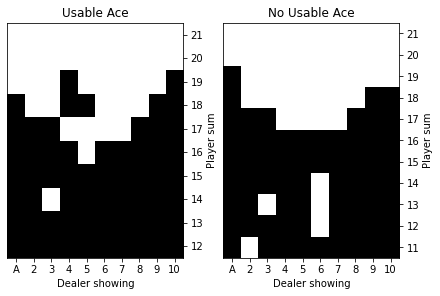

0.1


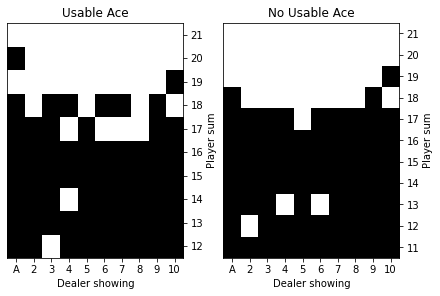

0.2


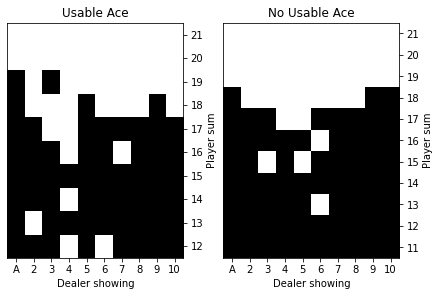

0.30000000000000004


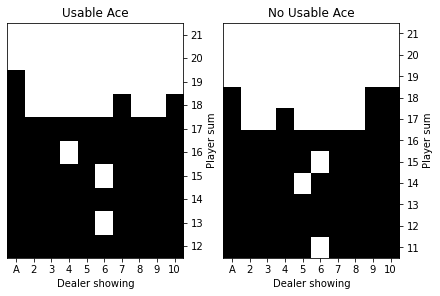

0.4


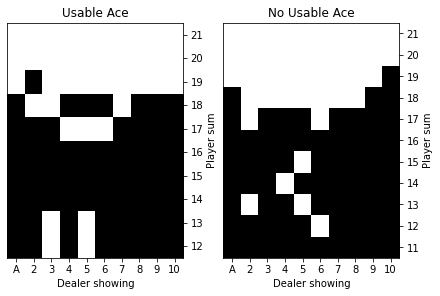

0.5


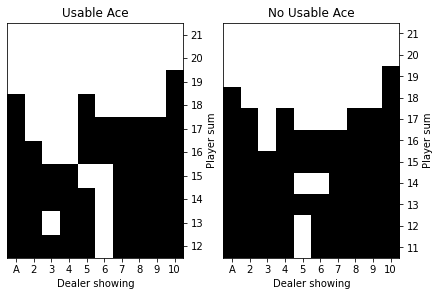

0.6000000000000001


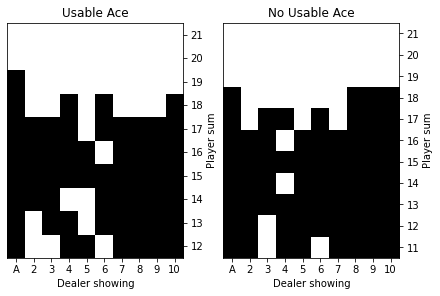

0.7000000000000001


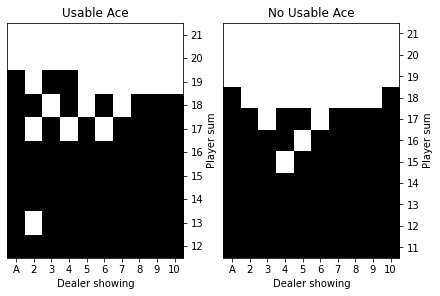

0.8


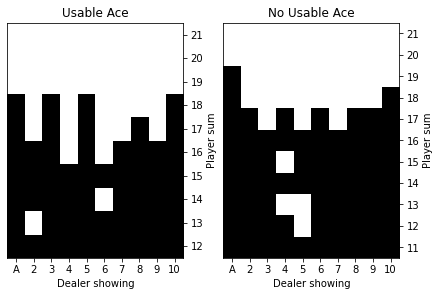

0.9


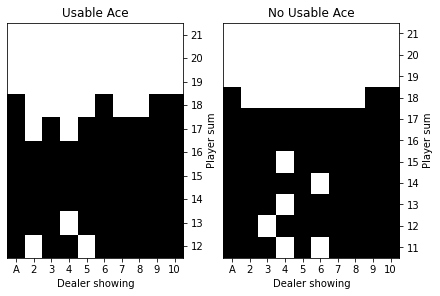

1.0


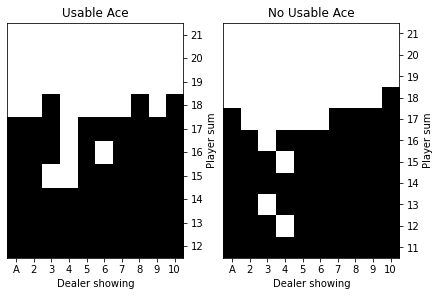

In [4]:
# creating a Blackjack environment
casino = BlackjackEnv()

# Factors
epsilon = 0.05
gamma = 1
lambda_vals = np.arange(0,1.1,0.1) 
Learning_episodes = 100000
Return_episodes = 10000
# To store average returns 
average_returns = list()

# Running episodes
for lambda_val in tqdm(lambda_vals):
    # Initialize Action value function
    Q = np.zeros((32,11,2,2))   
    N = np.zeros((32,11,2,2))
    progressBar = range(0,Learning_episodes)
    for episode in progressBar:
        # Eligibility trace
        e = np.zeros((32,11,2,2))
        starting_state = casino.reset() # Environment reset
        done = False  # Episode over flag
        # Lists to save the trajectory and the decisions of the agent
        actions, rewards, states = [], [], [starting_state]
        # Initilize Initial state and action
        possibleActions = casino.getAvailableActions()
        s = starting_state
        a = get_action(Q,s,possibleActions,epsilon=epsilon)  # Choosing epsilon-greedy Policy
        # simulate until the episode is over
        while not done:
            # Executing the action
            sPrime, r, done, _ = casino.step(action = a) # Observe sPrime
            # Save the action, reward and state
            actions.append(a)
            rewards.append(r)
            states.append(s)
            # Actions possible for next step
            possibleActions = casino.getAvailableActions()
            # Choose aPrime with epsilon-greedy Policy
            aPrime = get_action(Q,s,possibleActions,epsilon=epsilon)
            # Updating the Action value function 
            delta = r + (gamma*Q[sPrime][aPrime]) - Q[s][a]
            e[s][a] = e[s][a] + 1
            N[s][a] = N[s][a] + 1
            alpha = 1/(N[s][a]+1)
            Q = Q + alpha * delta * e
            e = gamma * lambda_val * e
            s = sPrime
            a = aPrime
    returns = list()
    progressBar = range(0,Return_episodes)
    for episode in progressBar:
        starting_state = casino.reset() # Environment reset
        done = False  # Episode over flag
        # Lists to save the trajectory and the decisions of the agent
        rewards = list()
        s = starting_state
        # simulate until the episode is over
        while not done:
            # Get possible action
            possibleActions = casino.getAvailableActions()
            # Choose aPrime with epsilon-greedy Policy
            a = get_action(Q,s,possibleActions,epsilon=0)           
            # Executing the action
            s, r, done, _ = casino.step(action = a)
            # save the reward 
            rewards.append(r)
        returns.append(sum(rewards))
    average_returns.append(np.average(returns))
    print(lambda_val)
    plotPolicy(Q)

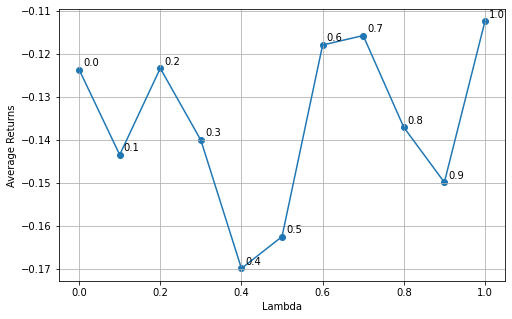

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(lambda_vals,average_returns)
ax.plot(lambda_vals,average_returns)
for lambda_val,average_return in zip(lambda_vals,average_returns):
    ax.annotate(str(round(lambda_val,2)),(lambda_val+0.01,average_return+0.001))
plt.xlabel("Lambda")
plt.ylabel("Average Returns")
plt.grid()
plt.show()

### Task 5.2)

Use your experiment from task 5.1) to select your favorite value for $\lambda$. Learn $Q$ using the Sarsa($\lambda$) algorithm for $1$ million episodes. After training, stop exploration and learning and report the average return for the next $10000$ episodes. Finally, visualize the resulting policy by using the helper function *plotPolicy(Q)*.

<div style="text-align: right; font-weight:bold"> 2 Points </div>

In [7]:
# creating a Blackjack environment
casino = BlackjackEnv()

# Initialize Action value function
Q = np.zeros((32,11,2,2))
N = np.zeros((32,11,2,2))
    
# Factors
epsilon = 0.05
gamma = 1
lambda_val = 0.8
Learning_episodes = 1000000
Return_episodes = 10000

progressBar = range(0,Learning_episodes)
for episode in tqdm(progressBar):
    # Eligibility trace
    e = np.zeros((32,11,2,2))
    starting_state = casino.reset() # Environment reset
    done = False  # Episode over flag
    # Lists to save the trajectory and the decisions of the agent
    actions, rewards, states = [], [], [starting_state]
    # Initilize Initial state and action
    possibleActions = casino.getAvailableActions()
    s = starting_state
    a = get_action(Q,s,possibleActions,epsilon=epsilon)  # Choosing epsilon-greedy Policy
    # simulate until the episode is over
    while not done:
        # Executing the action
        sPrime, r, done, _ = casino.step(action = a) # Observe sPrime
        # Save the action, reward and state
        actions.append(a)
        rewards.append(r)
        states.append(s)
        # Actions possible for next step
        possibleActions = casino.getAvailableActions()
        # Choose aPrime with epsilon-greedy Policy
        aPrime = get_action(Q,s,possibleActions,epsilon=epsilon)
        # Updating the Action value function
        delta = r + (gamma*Q[sPrime][aPrime]) - Q[s][a]
        e[s][a] = e[s][a] + 1
        N[s][a] = N[s][a] + 1
        alpha = 1/(N[s][a]+1)
        Q = Q + alpha * delta * e
        e = gamma * lambda_val * e
        s = sPrime
        a = aPrime
returns = list()
progressBar = range(0,Return_episodes)
for episode in tqdm(progressBar):
    starting_state = casino.reset() # Environment reset
    done = False  # Episode over flag
    # Lists to save the trajectory and the decisions of the agent
    rewards = list()
    s = starting_state
    # simulate until the episode is over
    while not done:
        # Get possible action
        possibleActions = casino.getAvailableActions()
        # Choose aPrime with epsilon-greedy Policy
        a = get_action(Q,s,possibleActions,epsilon=0)           
        # Executing the action
        s, r, done, _ = casino.step(action = a)
        # save the reward 
        rewards.append(r)
    returns.append(sum(rewards))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The average return of SARSA with the lambda value  0.8  is  -0.1684


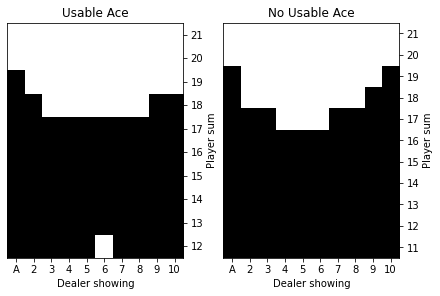

In [8]:
average_return = np.average(returns)
print("The average return of SARSA with the lambda value ",lambda_val," is ",average_return)
plotPolicy(Q)

### Task 5.3)

Now consider a simple coarse coding value function approximator that is based on a binary feature vector $\phi_{s, a} \in \mathbb{R}^{128}$ with $8 \times 4 \times 2 \times 2 = 128$ features. Each binary feature has a value of 1 iff $(s, a)$ lies within the cuboid of state-action-space corresponding to that feature. The cuboids have the following overlapping intervals:

$player(s) = \{[4, 7], [6, 9], [8, 11], [10, 13], [12, 15], [14, 17], [18, 20], [19, 21]\}$

$dealer(s) = \{[1,4], [3, 6], [5, 8], [7, 10]\}$

$usable\_ace(s) = \{0,1\}$

$a = \{0, 1\}$

where

* player(s) is the sum of the player’s cards (4–21) in state s
* dealer(s) is the value of the dealer’s first card (1–10) in state s

Implement a function $phi(s,a)$ which takes a state-action pair $(s,a)$ and maps it to a vector $\phi_{s,a}$ as described above.

<div style="text-align: right; font-weight:bold"> 3 Points </div>

In [9]:
# Overlapping intervals
player = np.array([ [4,7],[6,9],[8,11],[10,13],[12,15],[14,17],[18,20],[19,21] ] )
dealer = np.array([[1,4],[3,6],[5,8],[7,10]])
usable_ace =np.array([0,1])
action =np.array([0,1]) 
                
def phi(state, act):
    i1 = np.where(state[0]<=player)[0][0] +1
    i2 = np.where(state[1]<=dealer)[0][0] +1
    i3 =  np.where(state[2]<=usable_ace)[0][0] +1
    i4 = np.where(act<=a)[0][0] +1
    idx = ( i1*i2*i3*i4 )-1
    feat_vector = np.zeros(128)
    feat_vector[idx]=1
    return feat_vector

### Task 5.4)

Conduct one more Sarsa($\lambda$) experiment, but this time use a linear value function approximation $Q(s,a) = \theta \cdot \phi_{s,a}$. Use a constant exploration of $\varepsilon=0.05$, a constant step-size of $\alpha=0.02$, and your favorite $\lambda$.

Stop exploration and learning after $50000$ episodes and report the average return for the next $10000$ episodes.

To clarify, $\theta$ is a row vector which your algorithm learns instead of $Q(s,a)$. The row vector times column vector product $Q(s,a) = \theta \cdot \phi_{s,a}$ can also be understood as $Q(s,a) = \sum_{i=0}^{127} \theta(i)\phi_{s,a}(i)$.

<div style="text-align: right; font-weight:bold"> 4 Points </div>

In [10]:
# creating a Blackjack environment
casino = BlackjackEnv()

# Initialize Action value function
Q = np.zeros((32,11,2,2))
# Initialize row vector Theta
Theta = np.zeros((128))
    
# Factors
epsilon = 0.05
alpha = 0.02
gamma = 1
lambda_val = 0.8
Learning_episodes = 50000
Return_episodes = 10000

progressBar = range(0,Learning_episodes)
for episode in tqdm(progressBar):
    # Eligibility trace
    e = np.zeros((128))
    starting_state = casino.reset() # Environment reset
    done = False  # Episode over flag
    # Lists to save the trajectory and the decisions of the agent
    actions, rewards, states = [], [], [starting_state]
    # Initilize Initial state and action
    possibleActions = casino.getAvailableActions()
    s = starting_state
    a = get_action(Q,s,possibleActions,epsilon=epsilon)  # Choosing epsilon-greedy Policy
    # simulate until the episode is over
    while not done:
        # Executing the action
        sPrime, r, done, _ = casino.step(action = a) # Observe sPrime
        # Save the action, reward and state
        actions.append(a)
        rewards.append(r)
        states.append(s)
        # Actions possible for next step
        possibleActions = casino.getAvailableActions()
        # Choose aPrime with epsilon-greedy Policy
        aPrime = get_action(Q,s,possibleActions,epsilon=epsilon)  
        # Updating Tetha and Action-value function
        Phi = phi(s,a)
        e[np.where(Phi==1)[0][0]] += 1
        delta = r + (gamma*Q[sPrime][aPrime]) - Q[s][a]
        e = gamma * lambda_val * e 
        Theta = Theta + alpha * delta * e
        Q[s][a] = np.dot(Theta,Phi)
        s = sPrime
        a = aPrime
returns = list()
progressBar = range(0,Return_episodes)
for episode in tqdm(progressBar):
    starting_state = casino.reset() # Environment reset
    done = False  # Episode over flag
    # Lists to save the trajectory and the decisions of the agent
    rewards = list()
    s = starting_state
    # simulate until the episode is over
    while not done:
        # Get possible action
        possibleActions = casino.getAvailableActions()
        # Choose aPrime with epsilon-greedy Policy
        a = get_action(Q,s,possibleActions,epsilon=0)           
        # Executing the action
        s, r, done, _ = casino.step(action = a)
        # save the reward 
        rewards.append(r)
    returns.append(sum(rewards))

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The average return of SARSA with the lambda value  0.8  is  -0.4177


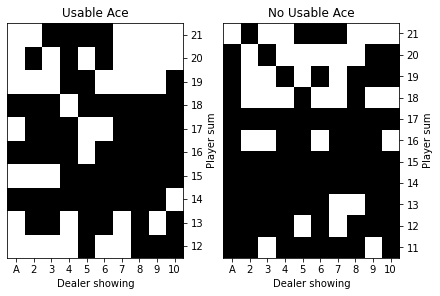

In [11]:
average_return = np.average(returns)
print("The average return of SARSA with the lambda value ",lambda_val," is ",average_return)
plotPolicy(Q)

### Task 5.5)

Implement the actor-critic version of TD(0) control. You can proceed as described on slide 4 in lecture 05. However, please adjust the update of the preferences $p(s,a)$ to

$$p[s_t][a_t] \leftarrow p[s_t][a_t] + \beta \delta_t [1 - \pi(s,a_t)]$$

This represents the learning rule for the actor. For the critic, you can update state values $V(s_t)$ according to

$$V(s_t) \leftarrow V(s_t) + \alpha \delta_t$$ 

after updating the actor for each step of the episode. Use $\alpha = \beta = 0.2$ and $\gamma = 0.9$ and learn for 1 million episodes. Report the mean return of the final $10000$ episodes.

Then, visualize the policy induced by $p$. It is possible to use *plotPolicy($\pi$)* for this purpose.

<div style="text-align: right; font-weight:bold"> 6 Points </div>

In [12]:
# creating a Blackjack environment
casino = BlackjackEnv()

# Initialize State value function
V =  np.zeros((32,11,2))
# Initialize Action value function
Q = np.zeros((32,11,2,2))
P = np.zeros((32,11,2,2))
pi =  np.zeros((32,11,2,2))
# Initialize row vector Theta
Theta = np.zeros((128))
    
# Factors
alpha = 0.2
beta = 0.2
gamma = 0.9
lambda_val = 0.8
Learning_episodes = 1000000
Return_episodes = 10000

progressBar = range(0,Learning_episodes)
for episode in tqdm(progressBar):
    # Eligibility trace
    e = np.zeros((128))
    starting_state = casino.reset() # Environment reset
    done = False  # Episode over flag
    # Lists to save the trajectory and the decisions of the agent
    actions, rewards, states = [], [], [starting_state]
    # Initilize Initial state and action
    possibleActions = casino.getAvailableActions()
    s = starting_state
    a = get_action(Q,s,possibleActions,epsilon=1)  # Choosing epsilon-greedy Policy
    # simulate until the episode is over
    while not done:
        # Executing the action
        sPrime, r, done, _ = casino.step(action = a) # Observe sPrime
        # Save the action, reward and state
        actions.append(a)
        rewards.append(r)
        states.append(s)
        # Updating State value function, Preference and Policy
        V[s] = V[s] + alpha*delta 
        pi[s][a]= np.exp(P[s][a])/np.sum([np.exp(P[s][b]) for b in [0,1]])
        P[s][a] = P[s][a] + beta*delta* (1-pi[s][a])
        # Actions possible for next step
        possibleActions = casino.getAvailableActions()
        # Choose aPrime with epsilon-greedy Policy
        aPrime = get_action(Q,s,possibleActions,epsilon=1-pi[s][a])    
        # Updating Tetha and Action-value function
        Phi = phi(s,a)
        e[np.where(Phi==1)[0][0]] += 1
        delta = r + (gamma*Q[sPrime][aPrime]) - Q[s][a]
        e = gamma * lambda_val * e 
        Theta = Theta + alpha * delta * e
        Q[s][a] = np.dot(Theta,Phi)
        s = sPrime
        a = aPrime
returns = list()
progressBar = range(0,Return_episodes)
for episode in tqdm(progressBar):
    starting_state = casino.reset() # Environment reset
    done = False  # Episode over flag
    # Lists to save the trajectory and the decisions of the agent
    rewards = list()
    s = starting_state
    # simulate until the episode is over
    while not done:
        # Get possible action
        possibleActions = casino.getAvailableActions()
        # Choose aPrime with epsilon-greedy Policy
        a = get_action(Q,s,possibleActions,epsilon=0)           
        # Executing the action
        s, r, done, _ = casino.step(action = a)
        # save the reward 
        rewards.append(r)
    returns.append(sum(rewards))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

The average return of actor-critic with the lambda value  0.8  is  -0.3234


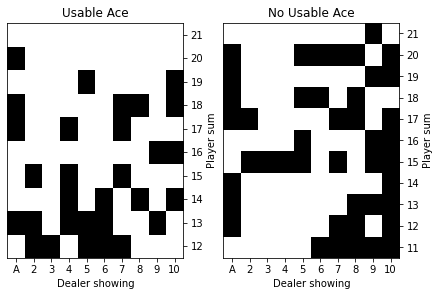

In [13]:
average_return = np.average(returns)
print("The average return of actor-critic with the lambda value ",lambda_val," is ",average_return)
plotPolicy(pi)